# Model for Predicting Likelihood to Vote by Demographic

This model trains a neural network on the British Election Study conducted after the 2017 election to predict the likelihood with which an individual will turn out to vote based on their demographic. 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
df=pd.read_stata('BES2017_W13_v1.0.dta')
#df=pd.read_stata('BES2015_W12_v1.0.dta')
df.shape

(31197, 312)

In [2]:
pd.__version__

'0.22.0'

### Some info on the dataset

Wave 11 was conducted by YouGov between 24th April 2017 and 3rd May 2017, N=31,014.<br>
Wave 12 was conducted by YouGov between 5th May 2017 and 7th June 2017, N=34,464.<br>
Wave 13 was conducted by YouGov between 9th June 2017 and 23rd June 2017 (Immediately after the election), N=31,196.<br>

## Data Preparation and Exploration

In [3]:
df.generalElectionVote.cat.categories

Index(['Conservative', 'Labour', 'Liberal Democrat',
       'Scottish National Party (SNP)', 'Plaid Cymru',
       'United Kingdom Independence Party (UKIP)', 'Green Party', 'Other',
       'Don't know'],
      dtype='object')

In [4]:
df.generalElectionVote.cat.rename_categories(['Conservative', 'Labour', 'Liberal Democrat',
       'SNP', 'Plaid Cymru','UKIP', 'Green Party', 'Other',"Don't know"],inplace=True)

In [5]:
df.generalElectionVote.cat.categories

Index(['Conservative', 'Labour', 'Liberal Democrat', 'SNP', 'Plaid Cymru',
       'UKIP', 'Green Party', 'Other', 'Don't know'],
      dtype='object')

In [6]:
df[['id','country', 'wt_new_W13','generalElectionVote']][0:10]

,id,country,wt_new_W13,generalElectionVote
0,2,England,0.638969,Conservative
1,3,England,0.407345,Labour
2,6,Wales,0.211374,Labour
3,7,Scotland,0.940523,SNP
4,8,England,0.492335,Conservative
5,9,Wales,0.743759,Liberal Democrat
6,14,England,0.835509,Conservative
7,15,England,0.567729,Conservative
8,18,Scotland,0.994050,SNP
9,29,Wales,0.867012,Plaid Cymru


In [8]:
G1=df.groupby(['generalElectionVote']).agg({'generalElectionVote':{'Count':'count'}})
np.array(G1.generalElectionVote.Count)/np.array(G1.generalElectionVote.Count).sum()

C:\Apps\Anaconda3\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


array([0.39894744, 0.38496044, 0.09420034, 0.04817745, 0.00692286,
       0.02663182, 0.02147499, 0.01275078, 0.00593388])

### Vote share by country

C:\Apps\Anaconda3\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


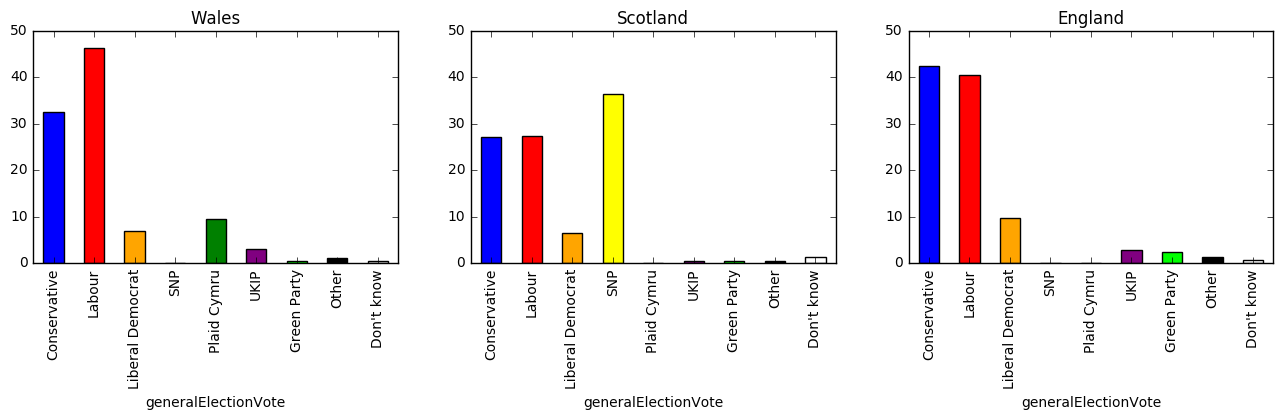

In [9]:
Regions=['Wales','Scotland','England']

plt.figure(figsize=(16, 3), facecolor='w', edgecolor='k')
plt.subplot(1,3,1)

for i in range(len(Regions)):
   
    G2=df[(df.genElecTurnoutRetro=='Yes, voted')&(df.country==Regions[i])
         ][['generalElectionVote','wt_new_W13']].groupby(['generalElectionVote']).agg({'wt_new_W13':{'Sum':'sum'}})
    G2=G2['wt_new_W13']
    G2['Sum']=G2['Sum']/G2[G2['Sum'].notnull()]['Sum'].sum()*100
    
    plt.subplot(1,3,i+1)
    G2['Sum'].plot(ax=plt.gca(), kind='bar', 
                   color=['blue','red','orange','yellow','green','purple','lime','black','white'], title=Regions[i],ylim=(0,50))

C:\Apps\Anaconda3\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


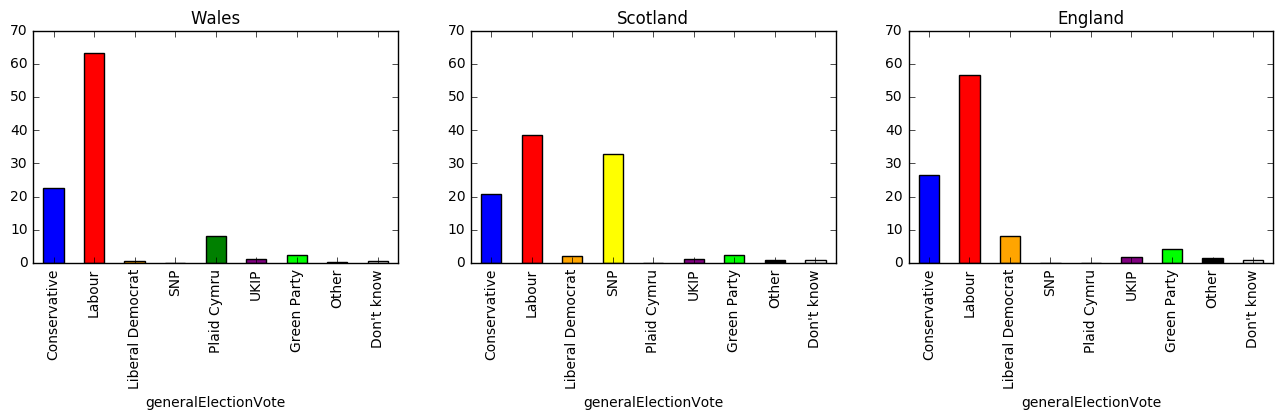

In [10]:
Regions=['Wales','Scotland','England']

plt.figure(figsize=(16, 3), facecolor='w', edgecolor='k')
plt.subplot(1,3,1)

for i in range(len(Regions)):
   
    G2=df[(df.profile_turnout_2015!='Yes, voted')&(df.genElecTurnoutRetro=='Yes, voted')&(df.country==Regions[i])
         ][['generalElectionVote','wt_new_W13']].groupby(['generalElectionVote']).agg({'wt_new_W13':{'Sum':'sum'}})
    G2=G2['wt_new_W13']
    G2['Sum']=G2['Sum']/G2[G2['Sum'].notnull()]['Sum'].sum()*100
    
    plt.subplot(1,3,i+1)
    G2['Sum'].plot(ax=plt.gca(), kind='bar', 
                   color=['blue','red','orange','yellow','green','purple','lime','black','white'], title=Regions[i], ylim=(0,70))

In [11]:
df.columns[df.columns.str.startswith('gen')]

Index(['generalElectionVote', 'genElecTurnoutRetro', 'gender'], dtype='object')

In [12]:
df.columns[df.columns.str.startswith('profile')]

Index(['profile_work_stat', 'profile_education_age', 'profile_ethnicity',
       'profile_marital_stat', 'profile_newspaper', 'profile_socialgrade_cie',
       'profile_religion', 'profile_lea', 'profile_oslaua',
       'profile_gross_personal', 'profile_household_children',
       'profile_religion_denom', 'profile_past_vote_2015',
       'profile_turnout_2015', 'profile_eurefvote', 'profile_eurefturnout'],
      dtype='object')

In [13]:
useVariables=list(df.columns[df.columns.str.startswith('profile')])
useVariables.extend(['generalElectionVote','country', 'wt_new_W13'])
df2=df[useVariables]
df2.head()

,profile_work_stat,profile_education_age,profile_ethnicity,profile_marital_stat,profile_newspaper,profile_socialgrade_cie,profile_religion,profile_lea,profile_oslaua,profile_gross_personal,profile_household_children,profile_religion_denom,profile_past_vote_2015,profile_turnout_2015,profile_eurefvote,profile_eurefturnout,generalElectionVote,country,wt_new_W13
0,Working part time (8-29 hours a week),20+,White British,Married,The Daily Telegraph,A,Yes - Roman Catholic,Surrey,Tandridge,"Â£50,000 to Â£59,999 per year",0,Roman Catholic,Conservative,"Yes, voted",Leave the EU,"Yes, voted",Conservative,England,0.638969
1,Retired,20+,White British,Widowed,The Mirror / Daily Record,E,Yes - Baptist,Lincolnshire,Boston,"Â£5,000 to Â£9,999 per year",0,Baptist,Labour,"Yes, voted",Leave the EU,"Yes, voted",Labour,England,0.407345
2,Working full time (30 or more hours per week),17-18,White British,Married,The Mirror / Daily Record,C1,"No, I do not regard myself as belonging to any...",Cardiff,Cardiff,"Â£30,000 to Â£34,999 per year",1,None,Labour,"Yes, voted",Leave the EU,"Yes, voted",Labour,Wales,0.211374
3,Retired,16,White British,Married,None,B,"No, I do not regard myself as belonging to any...",South Ayrshire,South Ayrshire,Don't know,0,NaN,Scottish National Party (SNP),"Yes, voted",Stay/remain in the EU,"Yes, voted",SNP,Scotland,0.940523
4,Working full time (30 or more hours per week),20+,White British,Married,The Times,C1,"No, I do not regard myself as belonging to any...",North Yorkshire,Craven,Prefer not to answer,0,None,United Kingdom Independence Party (UKIP),"Yes, voted",Leave the EU,"Yes, voted",Conservative,England,0.492335


In [14]:
[len(set(df.profile_education_age)),len(set(df.profile_ethnicity)),len(set(df.profile_socialgrade_cie)),
 len(set(df.profile_gross_personal)),len(set(df.profile_past_vote_2015)),len(set(df.profile_eurefvote)),
 len(set(df.profile_work_stat))]

[8, 17, 8, 17, 11, 4, 8]

## Feature Plots

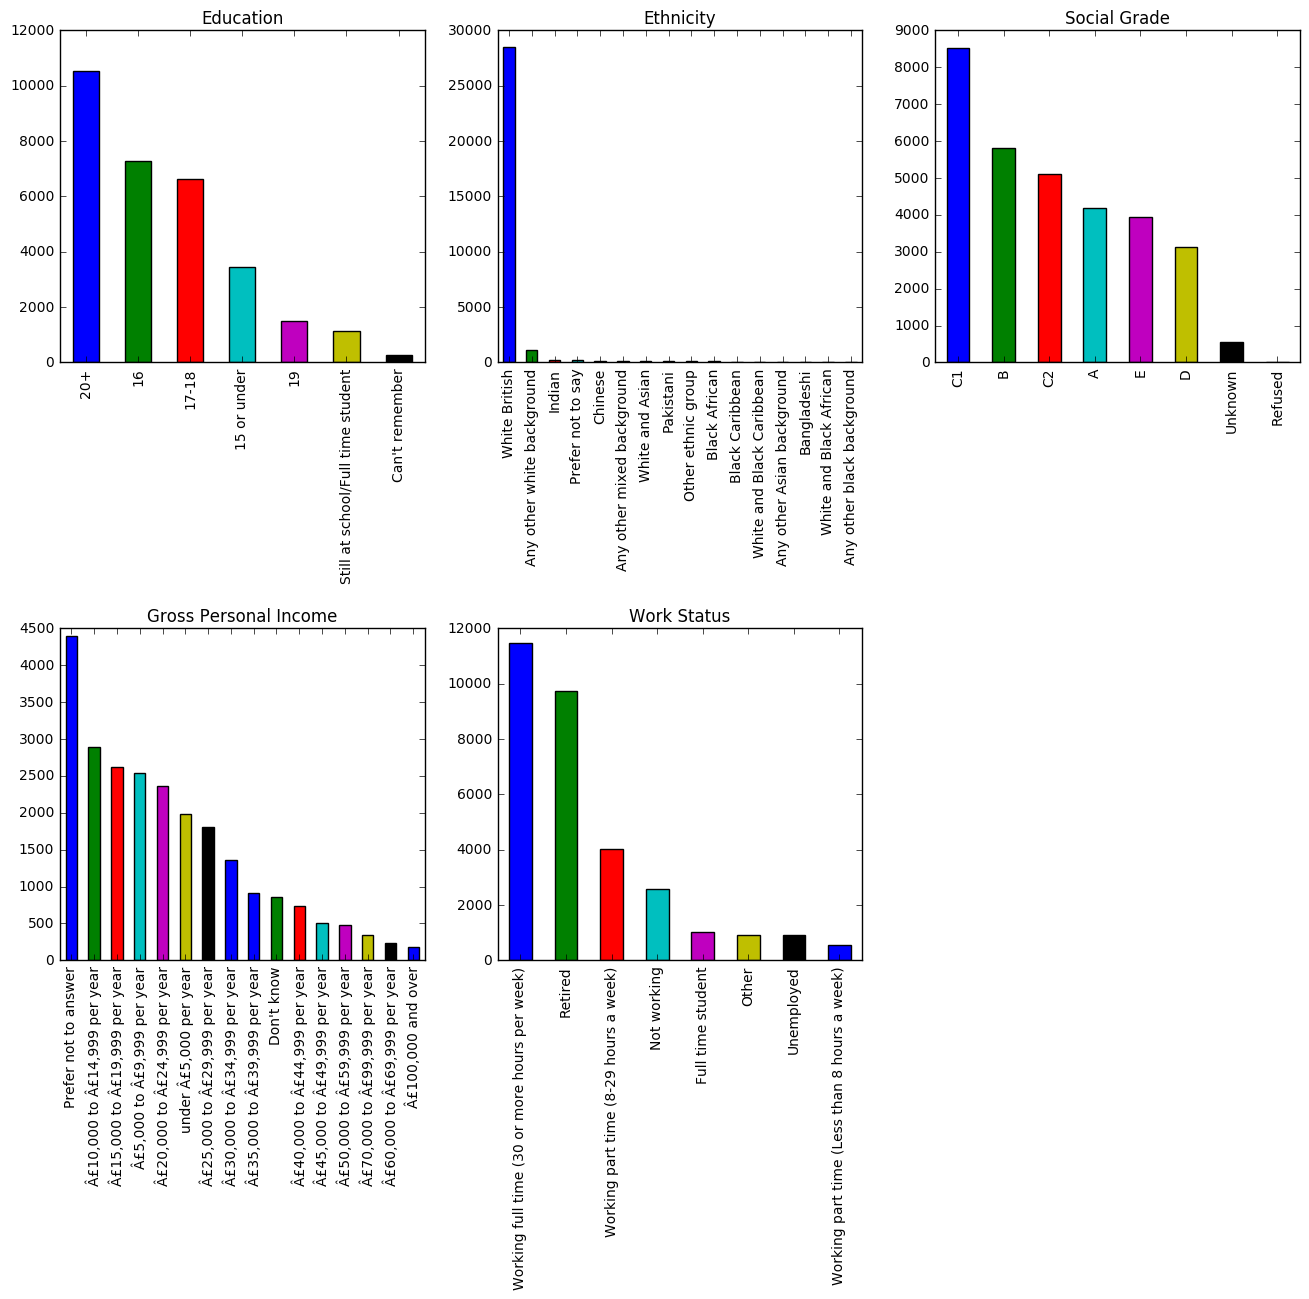

In [15]:
plotTitles=['Education','Ethnicity','Social Grade','Gross Personal Income','Work Status']
plotVariables=['profile_education_age','profile_ethnicity','profile_socialgrade_cie','profile_gross_personal',
              'profile_work_stat']
fig=plt.figure(figsize=(16, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.8)

for i in range(len(plotVariables)):
    plt.subplot(2,3,i+1)
    df[plotVariables[i]].value_counts().plot(kind='bar',title=plotTitles[i])
    


## Ethnicity

In [16]:
df2['BME']=(df.profile_ethnicity.isin(['White British','Any other white background'])).astype(int)
df2.loc[df.profile_ethnicity=='Prefer not to say','BME']=2
df2.loc[df.profile_ethnicity.isnull(),'BME']=3

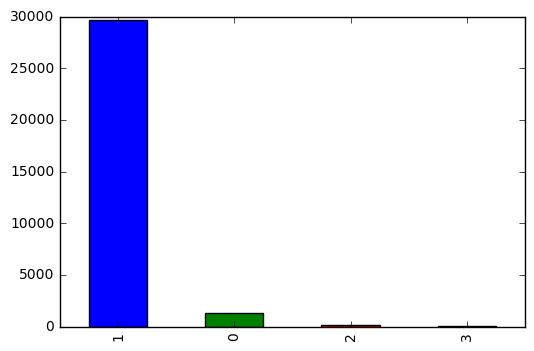

In [17]:
df2['BME'].value_counts().plot(kind='bar')

## Income

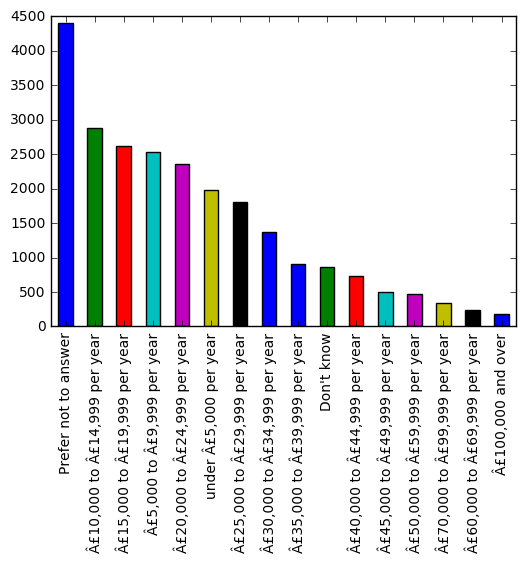

In [18]:
df.profile_gross_personal.value_counts().plot(kind='bar')

In [19]:
df2.profile_gross_personal.cat.categories

Index(['under Â£5,000 per year', 'Â£5,000 to Â£9,999 per year',
       'Â£10,000 to Â£14,999 per year', 'Â£15,000 to Â£19,999 per year',
       'Â£20,000 to Â£24,999 per year', 'Â£25,000 to Â£29,999 per year',
       'Â£30,000 to Â£34,999 per year', 'Â£35,000 to Â£39,999 per year',
       'Â£40,000 to Â£44,999 per year', 'Â£45,000 to Â£49,999 per year',
       'Â£50,000 to Â£59,999 per year', 'Â£60,000 to Â£69,999 per year',
       'Â£70,000 to Â£99,999 per year', 'Â£100,000 and over',
       'Prefer not to answer', 'Don't know'],
      dtype='object')

In [20]:
df2['income']=np.nan
df2.loc[df.profile_gross_personal.isin(['under Â£5,000 per year','Â£5,000 to Â£9,999 per year']),'income']='very low'
df2.loc[df.profile_gross_personal.isin(['Â£10,000 to Â£14,999 per year', 'Â£15,000 to Â£19,999 per year']),'income']='low'
df2.loc[df.profile_gross_personal.isin(['Â£20,000 to Â£24,999 per year', 'Â£25,000 to Â£29,999 per year',
       'Â£30,000 to Â£34,999 per year', 'Â£35,000 to Â£39,999 per year']),'income']='mid'
df2.loc[df.profile_gross_personal.isin(['Â£40,000 to Â£44,999 per year', 'Â£45,000 to Â£49,999 per year',
       'Â£50,000 to Â£59,999 per year', 'Â£60,000 to Â£69,999 per year']),'income']='high'
df2.loc[df.profile_gross_personal.isin(['Â£70,000 to Â£99,999 per year', 'Â£100,000 and over']),'income']='very high' 
df2.loc[df.profile_gross_personal.isin(['Prefer not to answer', "Don't know"]),'income']='no answer'  


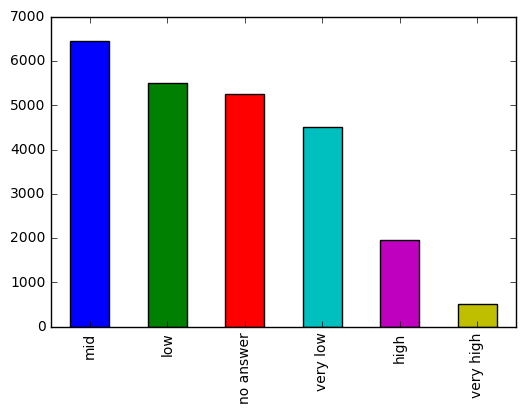

In [21]:
df2.income.value_counts().plot(kind='bar')

In [22]:
df2['vote2017']=0
df2.loc[df2.generalElectionVote=='Labour','vote2017']=1
df2.loc[df2.generalElectionVote=='Liberal Democrat','vote2017']=2
df2.loc[df2.generalElectionVote=='SNP','vote2017']=3
df2.loc[df2.generalElectionVote=='Plaid Cymru','vote2017']=4
df2.loc[df2.generalElectionVote=='UKIP','vote2017']=5
df2.loc[df2.generalElectionVote=='Green Party','vote2017']=6
df2.loc[df2.generalElectionVote=='Other','vote2017']=7
df2.loc[df2.generalElectionVote=="Don't know",'vote2017']=8

## Get Dummies

In [23]:

dfX=pd.concat([
    pd.get_dummies(df2.BME,prefix='B',dummy_na=True,drop_first=True),
    pd.get_dummies(df2.income,prefix='I',dummy_na=True,drop_first=True),
    pd.get_dummies(df2.profile_education_age,prefix='E',dummy_na=True,drop_first=True),  
    pd.get_dummies(df2.profile_socialgrade_cie,prefix='S',dummy_na=True,drop_first=True),  
    pd.get_dummies(df2.profile_work_stat,prefix='W',dummy_na=True,drop_first=True),  
    pd.get_dummies(df2.profile_past_vote_2015,prefix='V',dummy_na=True,drop_first=True),
    pd.get_dummies(df2.profile_eurefvote,prefix='EU',dummy_na=True,drop_first=True),
    pd.get_dummies(df2.country,prefix='C',dummy_na=True,drop_first=True),
    df2[['vote2017','wt_new_W13']]
          ],axis=1)
dfX.head()

,B_1.0,B_2.0,B_3.0,B_nan,I_low,I_mid,I_no answer,I_very high,I_very low,I_nan,...,V_Don't know,V_nan,EU_Leave the EU,EU_Don't know,EU_nan,C_Scotland,C_Wales,C_nan,vote2017,wt_new_W13
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.638969
1,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0.407345
2,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0.211374
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,3,0.940523
4,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0.492335


In [24]:
dfX.shape

(31197, 51)

## Neural Newtork Model

In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [69]:
mlp = MLPClassifier(hidden_layer_sizes=(50,10,5, ), verbose=False, random_state=0, max_iter=200, epsilon=1e-8,
                   activation='relu', solver='adam', learning_rate='constant', learning_rate_init=0.01, alpha = 0.0001)

In [72]:
X, y = dfX[dfX.columns.difference(['vote2017','wt_new_W13'])], dfX['vote2017']
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.33) #, random_state=42
[xTrain.shape,xTest.shape,yTrain.shape,yTest.shape]

[(20901, 49), (10296, 49), (20901,), (10296,)]

In [73]:
mlp.fit( xTrain, yTrain )
yPred=mlp.predict(xTest)
print(mlp.score(xTrain,yTrain))
print(mlp.score(xTest,yTest))

0.7388641691785082
0.7059052059052059


In [74]:
(yPred==yTest).mean()

0.7059052059052059